In [1]:
import mne 
import warnings
warnings.filterwarnings('ignore')

# Load the data
epochs = mne.read_epochs('epochs_for_localizer-epo.fif')

epochs

Reading c:\Users\antoi\Documents\Fichier Antoine\Fosca\Antoine_21022024\epochs_for_localizer-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2340 matching events found
No baseline correction applied
0 projection items activated


Number of events,2340
Events,0: 3681: 2882: 3613: 3894: 3875: 367999: 180
Time range,-0.200 – 0.500 s
Baseline,off


We will now create the optimal machine learning model

In [2]:
import sys
sys.path.append('All_analyses')

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from mne.decoding import UnsupervisedSpatialFilter

nb_time_points = 2

param_grid = {
    'baggingclassifier__base_estimator__C': [0.1, 1, 10, 100],
    'baggingclassifier__base_estimator__kernel': ['linear'],
    'baggingclassifier__base_estimator__degree': [2, 3, 4, 5],
    'baggingclassifier__base_estimator__gamma': ['scale', 'auto'] + [0.1, 1, 10, 100],
    'baggingclassifier__base_estimator__coef0': [0, 1, 2, 3, 4],
    'baggingclassifier__base_estimator__shrinking': [True, False],
    'baggingclassifier__base_estimator__tol': [1e-3, 1e-4, 1e-5],
    'baggingclassifier__base_estimator__max_iter': [100, 500, 1000, 5000],
}

epochs.equalize_event_counts()

pca = UnsupervisedSpatialFilter(PCA(50), average=False)

X_all = pca.fit_transform(epochs.get_data())
y_all = epochs.events[:, 2]

best_model = None
best_score = 0
best_scores = [] # For plotting

data_train, data_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

for time in range(nb_time_points, len(epochs.times) - nb_time_points):
    print(time/len(epochs.times)*100)

    # Select the data
    X = np.mean(data_train[:,:,time-nb_time_points:time+nb_time_points+1], axis=2)
    y = y_train

    # Preprocess
    preprocessing = StandardScaler()

    # Choose a model
    model = make_pipeline(preprocessing, BaggingClassifier(SVC(random_state=0), n_estimators = 20, n_jobs=-2))

    # Hyperparameter search
    search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=5, n_jobs=-2)
    search.fit(X, y)

    X_test = np.mean(data_test[:,:,time-nb_time_points:time+nb_time_points+1], axis=2)
    y_test = y_test
    best_scores.append(search.score(X_test, y_test))

    # Save the best model
    if search.best_score_ > best_score:
        best_model = search.best_estimator_
        best_score = search.best_score_
        print('Test of best model:', best_model.score(X_test, y_test))
        print('New best score:', best_score)

Dropped 1080 epochs: 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 18, 19, 20, 22, 23, 28, 29, 31, 32, 34, 35, 39, 41, 42, 43, 44, 47, 52, 55, 56, 58, 59, 63, 64, 65, 66, 67, 68, 70, 76, 79, 83, 88, 89, 91, 92, 94, 100, 101, 102, 103, 104, 106, 111, 112, 115, 116, 118, 123, 124, 126, 127, 128, 131, 135, 137, 138, 140, 141, 147, 148, 149, 150, 151, 152, 153, 155, 159, 160, 161, 162, 164, 167, 171, 173, 174, 176, 177, 183, 184, 186, 187, 188, 190, 195, 196, 197, 198, 200, 203, 207, 208, 209, 210, 211, 212, 213, 219, 220, 222, 223, 227, 231, 232, 233, 234, 235, 236, 237, 238, 239, 245, 246, 247, 250, 251, 256, 258, 260, 262, 263, 268, 269, 270, 271, 272, 275, 280, 281, 282, 284, 286, 293, 294, 295, 296, 298, 304, 305, 306, 307, 308, 309, 310, 316, 317, 318, 319, 320, 321, 323, 328, 329, 330, 331, 332, 335, 340, 341, 342, 344, 346, 347, 352, 353, 354, 355, 357, 358, 365, 366, 367, 368, 370, 376, 377, 378, 379, 380, 382, 383, 388, 389, 390, 391, 392, 393, 400, 401, 406, 407, 412, 413, 414, 415, 416, 41

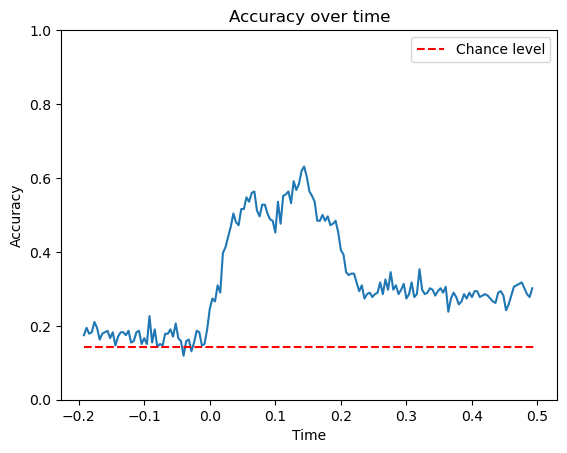

In [3]:
# Plotting the scores

import matplotlib.pyplot as plt
plt.plot(epochs.times[nb_time_points:-nb_time_points], best_scores)
plt.hlines(1/7, epochs.times[nb_time_points], epochs.times[-nb_time_points], colors='r', linestyles='dashed', label='Chance level')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy over time')
plt.legend()
plt.show()

In [4]:
max(best_scores), epochs.times[np.argmax(best_scores) + nb_time_points]

(0.6309523809523809, 0.144)

We just test what we had above to see if the model was trained well

We now train the model on all the data we have

In [16]:
time = np.argmax(best_scores) + nb_time_points # Index of the time point that has the best score
time

86

In [20]:
epochs

Number of events,1260
Events,0: 1801: 1802: 1803: 1804: 1805: 180999: 180
Time range,-0.200 – 0.500 s
Baseline,off


In [17]:
pca = UnsupervisedSpatialFilter(PCA(50), average=False)
pca = pca.fit(epochs.get_data())
pca_data = pca.transform(epochs.get_data())

y_all = epochs.events[:, 2]

## TRAINING

# Select the data
X = np.mean(pca_data[:,:,time-nb_time_points:time+nb_time_points+1], axis=2)
y = y_all

# Preprocess
preprocessing = StandardScaler()

# Choose a model
model = make_pipeline(preprocessing, BaggingClassifier(SVC(random_state=0, probability = True), n_estimators=30, n_jobs=-2))

# Hyperparameter search
search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=5, n_jobs=-2)
search.fit(X, y)

model = search.best_estimator_
print(model.score(X, y))

0.7873015873015873


In [123]:
from joblib import dump, load
dump(model, 'best_model.joblib') 

['best_model.joblib']

In [86]:
load ('best_model.joblib')

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(estimator=SVC(C=0.1, coef0=3, degree=2,
                                                 gamma=10, kernel='linear',
                                                 max_iter=5000,
                                                 probability=True,
                                                 random_state=0,
                                                 shrinking=False, tol=1e-05),
                                   n_jobs=-2))])

We then try the model on the maintenance data

In [18]:
epochs_maintenance = mne.read_epochs('epochs_maintenance-epo.fif')

Reading c:\Users\antoi\Documents\Fichier Antoine\Fosca\Antoine_21022024\epochs_maintenance-epo.fif ...
    Found the data of interest:
        t =    5780.00 ...   11780.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
180 matching events found
No baseline correction applied
0 projection items activated


In [19]:
data = epochs_maintenance.get_data()
pca_data = pca.transform(data)

predicted_positions = np.zeros((data.shape[0], data.shape[2]))

for time in range(nb_time_points, len(epochs_maintenance.times) - nb_time_points):
    print(time/data.shape[2]*100)

    X = np.mean(pca_data[:,:,time-nb_time_points:time+nb_time_points+1], axis=2)

    predicted_positions[:, time] = model.predict(X)

0.13324450366422386
0.19986675549633579
0.2664890073284477
0.3331112591605596
0.39973351099267157
0.4663557628247834
0.5329780146568954
0.5996002664890073
0.6662225183211192
0.7328447701532311
0.7994670219853431
0.866089273817455
0.9327115256495668
0.9993337774816788
1.0659560293137909
1.1325782811459029
1.1992005329780147
1.2658227848101267
1.3324450366422385
1.3990672884743505
1.4656895403064623
1.5323117921385743
1.5989340439706863
1.6655562958027983
1.73217854763491
1.798800799467022
1.8654230512991337
1.9320453031312457
1.9986675549633577
2.0652898067954695
2.1319120586275817
2.1985343104596935
2.2651565622918057
2.331778814123917
2.3984010659560293
2.465023317788141
2.5316455696202533
2.598267821452365
2.664890073284477
2.731512325116589
2.798134576948701
2.8647568287808127
2.9313790806129245
2.9980013324450367
3.0646235842771485
3.1312458361092603
3.1978680879413726
3.264490339773484
3.3311125916055966
3.397734843437708
3.46435709526982
3.530979347101932
3.597601598934044
3.6642

In [24]:
predicted_positions

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,0.0,0.0
1,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,999.0,999.0,999.0,999.0,999.0,3.0,3.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0
4,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,1.0,5.0,5.0,5.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0
176,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0
177,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0
178,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0


In [44]:
## Predicts 4 most of the time

import pandas as pd

predicted_positions = pd.DataFrame(predicted_positions)
nb_positions = len(set(epochs.events[:, 2]))
list_positions = list(sorted(set(epochs.events[:, 2])))
epochs_maintenance.metadata["PresentedPositions"]

frequences_of_presented_positions = []
frequences_of_non_presented_positions = []
frequences_999 = []
frequencies_of_all_positions = {position: 0 for position in list_positions}
recording_frequence_of_positions = []

for i in range(len(predicted_positions)):
    presented_positions = set(epochs_maintenance.metadata["PresentedPositions"][i])
    frequence_of_positions = {position: 0 for position in list_positions}

    count = predicted_positions.iloc[i,:].value_counts()

    for position in count.keys():
        frequence_of_positions[position] += count[position]/len(predicted_positions.iloc[i,:])
        frequencies_of_all_positions[position] += count[position]/len(predicted_positions.iloc[i,:])
    
    recording_frequence_of_positions.append(frequence_of_positions)

    frequences_of_non_presented_positions.append(0)
    frequences_of_presented_positions.append(0)

    for position in list_positions:
        if position in presented_positions:
            frequences_of_presented_positions[i] += frequence_of_positions[position]
        elif position == 999:
            frequences_999.append(frequence_of_positions[position])
        else:
            frequences_of_non_presented_positions[i] += frequence_of_positions[position]


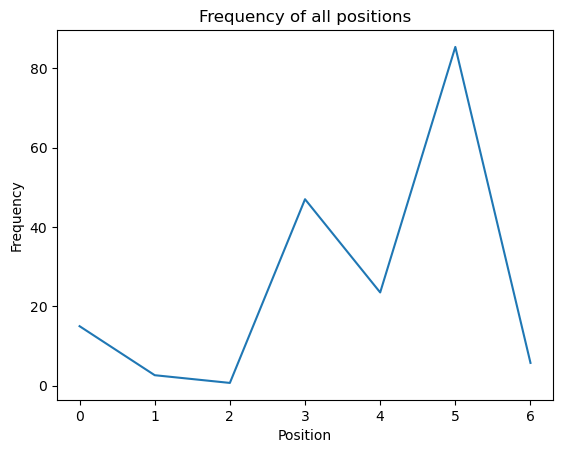

          0         1         2         3         4         5    999
0    0.051965  0.079947  0.000000  0.231179  0.001332  0.635576  0.0
1    0.005330  0.200533  0.000000  0.450366  0.003997  0.339773  0.0
2    0.069287  0.014657  0.000000  0.215190  0.000666  0.700200  0.0
3    0.119254  0.185210  0.000000  0.345769  0.000000  0.349767  0.0
4    0.075949  0.065956  0.000000  0.309793  0.020653  0.527648  0.0
..        ...       ...       ...       ...       ...       ...  ...
173  0.003331  0.054630  0.000000  0.069287  0.007995  0.864757  0.0
174  0.008661  0.000000  0.005330  0.034644  0.000000  0.951366  0.0
175  0.002665  0.017322  0.003331  0.047968  0.000000  0.928714  0.0
176  0.002665  0.002665  0.000000  0.001332  0.000000  0.993338  0.0
177  0.002665  0.060626  0.003331  0.110593  0.000000  0.822785  0.0

[178 rows x 7 columns]


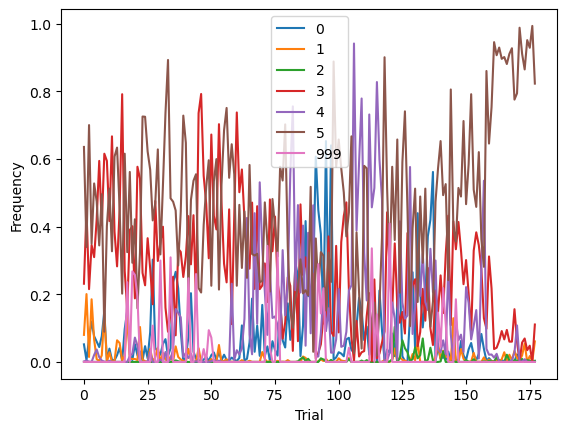

In [45]:
plt.plot(frequencies_of_all_positions.values())
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Frequency of all positions')
plt.show()

recording_frequence_of_positions = pd.DataFrame(recording_frequence_of_positions[2:])
print(recording_frequence_of_positions)
recording_frequence_of_positions.plot()
plt.xlabel('Trial')
plt.ylabel('Frequency')
plt.show()

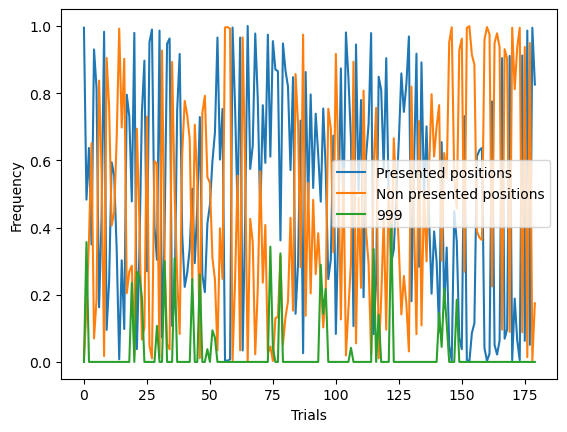

0.5075283144570286
0.46062995040343474


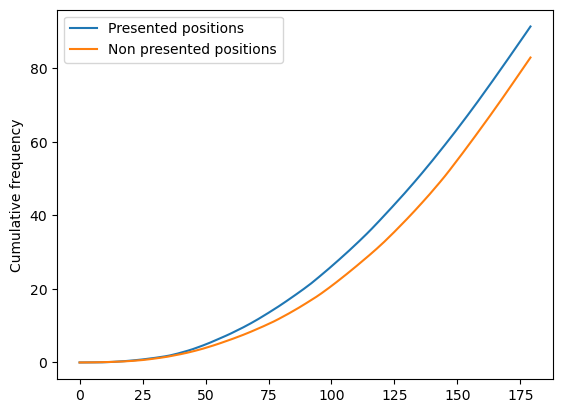

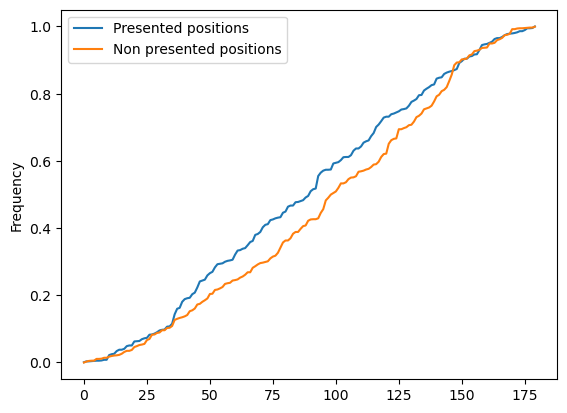

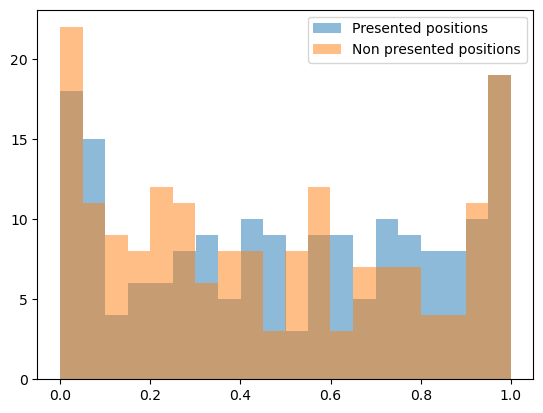

In [47]:
plt.plot(frequences_of_presented_positions, label='Presented positions')
plt.plot(frequences_of_non_presented_positions, label='Non presented positions')
plt.plot(frequences_999, label='999')
plt.xlabel('Trials')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(np.mean(frequences_of_presented_positions))
print(np.mean(frequences_of_non_presented_positions))

sorted_freq = np.cumsum(sorted(frequences_of_presented_positions))
sorted_freq_non = np.cumsum(sorted(frequences_of_non_presented_positions))
plt.plot(sorted_freq, label='Presented positions')
plt.plot(sorted_freq_non, label='Non presented positions')
plt.ylabel('Cumulative frequency')
plt.legend()
plt.show()

sorted_freq = sorted(frequences_of_presented_positions)
sorted_freq_non = sorted(frequences_of_non_presented_positions)
plt.plot(sorted_freq, label='Presented positions')
plt.plot(sorted_freq_non, label='Non presented positions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(frequences_of_presented_positions, bins=20, alpha=0.5, label='Presented positions')
plt.hist(frequences_of_non_presented_positions, bins=20, alpha=0.5, label='Non presented positions')
plt.legend()
plt.show()